Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as surprise_split



In [2]:
import pandas as pd

df = pd.read_excel("online_course_recommendation_v2.xlsx")
sample_df = df.sample(300, random_state=42)  # pick 300 random rows
sample_df.to_excel("sample_data.xlsx", index=False)

Basic Info

In [3]:
print("Shape of dataset:", df.shape)

Shape of dataset: (100000, 14)


Checking Missing Values

In [4]:
print("\nMissing values:\n", df.isnull().sum())


Missing values:
 user_id                     0
course_id                   0
course_name                 0
instructor                  0
course_duration_hours       0
certification_offered       0
difficulty_level            0
rating                      0
enrollment_numbers          0
course_price                0
feedback_score              0
study_material_available    0
time_spent_hours            0
previous_courses_taken      0
dtype: int64


No Null values

In [5]:
print("\nSummary statistics:\n", df.describe(include="all"))


Summary statistics:
               user_id      course_id                           course_name  \
count   100000.000000  100000.000000                                100000   
unique            NaN            NaN                                    20   
top               NaN            NaN  Networking and System Administration   
freq              NaN            NaN                                  5107   
mean     24935.663570    5006.863560                                   NaN   
std      14406.960108    2882.085456                                   NaN   
min          1.000000       1.000000                                   NaN   
25%      12487.750000    2523.000000                                   NaN   
50%      24793.500000    5012.000000                                   NaN   
75%      37382.250000    7502.000000                                   NaN   
max      49999.000000    9999.000000                                   NaN   

              instructor  course_duration

Visualizations

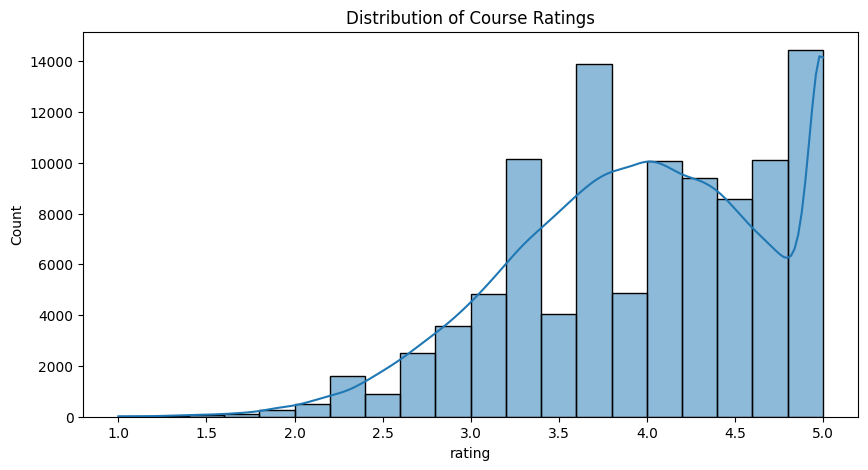

In [6]:
# Rating Distrubtion
plt.figure(figsize=(10,5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title("Distribution of Course Ratings")
plt.show()

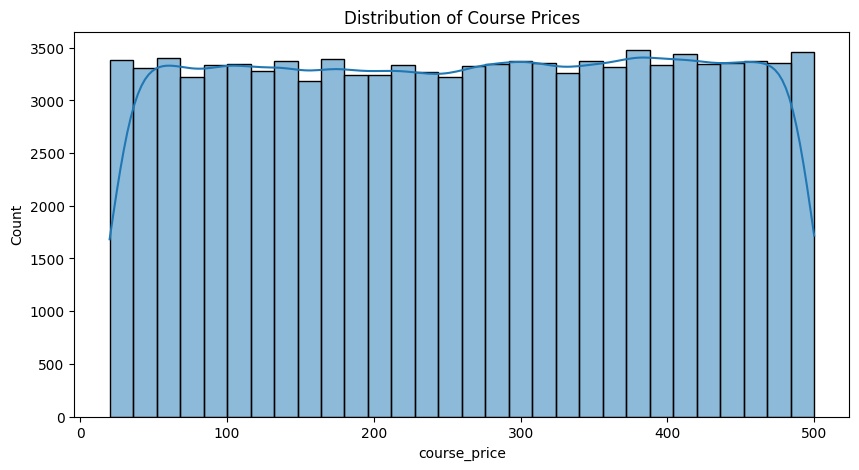

In [7]:
# Course Price Distribution
plt.figure(figsize=(10,5))
sns.histplot(df['course_price'], bins=30, kde=True)
plt.title("Distribution of Course Prices")
plt.show()


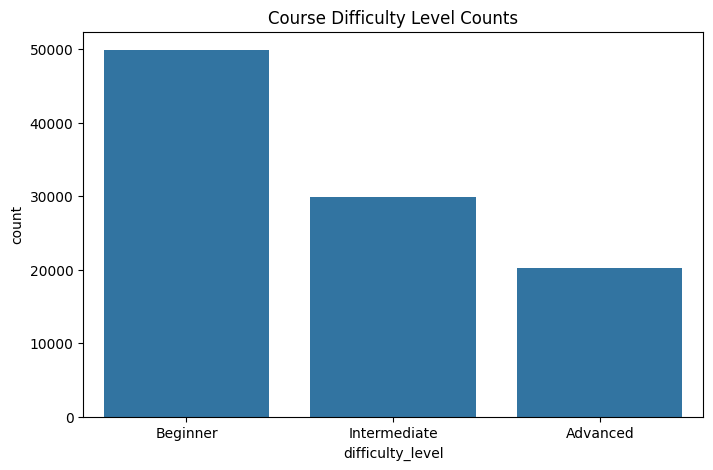

In [8]:
# Difficulty Level Counts
plt.figure(figsize=(8,5))
sns.countplot(x='difficulty_level', data=df, order=df['difficulty_level'].value_counts().index)
plt.title("Course Difficulty Level Counts")
plt.show()

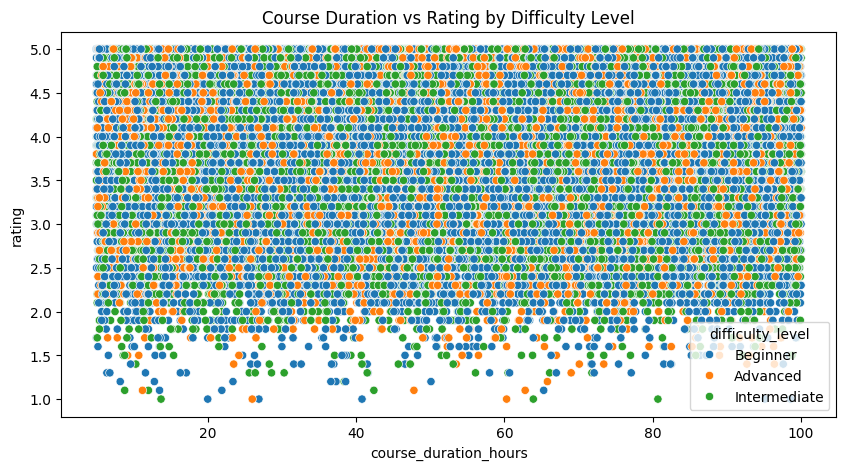

In [9]:
# Course Duration vs Rating
plt.figure(figsize=(10,5))
sns.scatterplot(x='course_duration_hours', y='rating', data=df, hue='difficulty_level')
plt.title("Course Duration vs Rating by Difficulty Level")
plt.show()

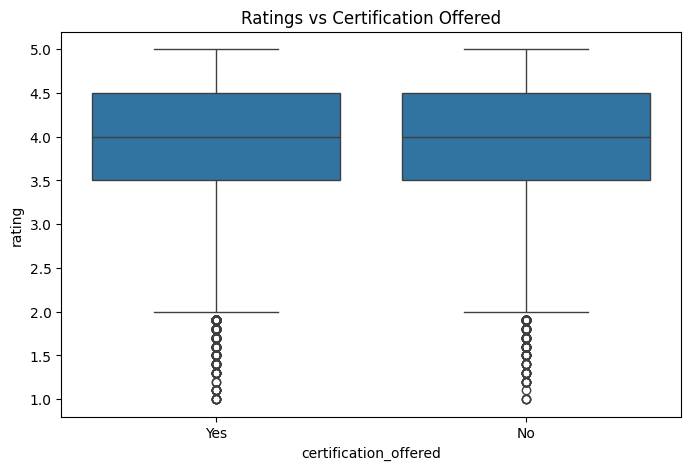

In [10]:
# Certification vs Ratings
plt.figure(figsize=(8,5))
sns.boxplot(x='certification_offered', y='rating', data=df)
plt.title("Ratings vs Certification Offered")
plt.show()


Standardisation

In [11]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("\nPreview of standardized data:\n", df_scaled.head())


Preview of standardized data:
     user_id  course_id                       course_name       instructor  \
0 -0.634395   1.512501              Python for Beginners      Emma Harris   
1 -1.671052  -1.068282   Cybersecurity for Professionals  Alexander Young   
2  0.917848   1.573222  DevOps and Continuous Deployment   Dr. Mia Walker   
3  1.374158  -0.450670   Project Management Fundamentals   Benjamin Lewis   
4 -0.947510  -0.571070       Ethical Hacking Masterclass     Daniel White   

   course_duration_hours certification_offered difficulty_level    rating  \
0              -0.484388                   Yes         Beginner  1.424941   
1              -0.586491                   Yes         Beginner  0.465976   
2              -1.421546                   Yes         Beginner -0.082004   
3               0.215745                   Yes         Beginner -1.177963   
4              -0.787050                   Yes         Beginner -1.588948   

   enrollment_numbers  course_price  feedb

Collaborative Filtering

In [12]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'course_id', 'rating']], reader)

trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

svd = SVD()
svd.fit(trainset)
svd_preds = svd.test(testset)

In [ ]:
# Convert Surprise predictions to DataFrame
svd_preds_df = pd.DataFrame(
    [(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in svd_preds],
    columns=['user_id', 'course_id', 'true_rating', 'svd_pred']
)

# Calculate RMSE 
mse = mean_squared_error(svd_preds_df['true_rating'], svd_preds_df['svd_pred'])
svd_rmse = np.sqrt(mse)

print("SVD RMSE:", svd_rmse)


SVD RMSE: 0.7424126436321626


Content-based - Random Forest & XGBoost

In [14]:
df_encoded = df.copy()
cat_cols = ['course_name', 'instructor', 'certification_offered',
            'difficulty_level', 'study_material_available']

for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])



In [15]:
# Features & Target
X = df_encoded.drop(['rating'], axis=1)
y = df_encoded['rating']


In [16]:
# Align splits with Surprise testset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [17]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [18]:
rf_preds = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(rf_mse)

print("Random Forest RMSE:", rf_rmse)


Random Forest RMSE: 0.7430814285460241


In [19]:
# XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
xgb_preds = xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)

print("XGBoost RMSE:", xgb_rmse)


XGBoost RMSE: 0.7407759868883423


Hybrid Model

In [ ]:

hybrid_df = pd.DataFrame({
    "true_rating": y_test.values,
    "rf_pred": rf_preds,
    "xgb_pred": xgb_preds
}).reset_index(drop=True)


In [22]:
# Merge with SVD predictions using common user_id + course_id
merged = pd.merge(
    svd_preds_df[['user_id','course_id','true_rating','svd_pred']],
    df_encoded[['user_id','course_id']].iloc[y_test.index].reset_index(drop=True),
    left_index=True, right_index=True
)


In [ ]:
# Hybrid: weighted average of SVD + RF + XGB
w_svd, w_rf, w_xgb = 0.5, 0.25, 0.25  # you can tune these weights
hybrid_preds = (w_svd * merged['svd_pred'] +
                w_rf * hybrid_df['rf_pred'] +
                w_xgb * hybrid_df['xgb_pred'])

# Compute MSE, RMSE
hybrid_mse = mean_squared_error(merged['true_rating'], hybrid_preds)
hybrid_rmse = np.sqrt(hybrid_mse)

print("Hybrid MSE:", hybrid_mse)
print("Hybrid RMSE:", hybrid_rmse)


Hybrid MSE: 0.5319669404344645
Hybrid RMSE: 0.7293606381170186


Evaluation Comparison

In [24]:
print("\nModel Performance Summary:")
print(f"SVD - RMSE: {svd_rmse:.4f}")
print(f"Random Forest - RMSE: {rf_rmse:.4f}")
print(f"XGBoost - RMSE: {xgb_rmse:.4f}")
print(f"Hybrid (SVD+RF+XGB) - RMSE: {hybrid_rmse:.4f}")

best_model = min([
    ("SVD", svd_rmse),
    ("Random Forest", rf_rmse),
    ("XGBoost", xgb_rmse),
    ("Hybrid", hybrid_rmse)
], key=lambda x: x[1])

print(f"\n Best Model for Recommendation: {best_model[0]} (RMSE={best_model[1]:.4f})")


Model Performance Summary:
SVD - RMSE: 0.7424
Random Forest - RMSE: 0.7431
XGBoost - RMSE: 0.7408
Hybrid (SVD+RF+XGB) - RMSE: 0.7294

 Best Model for Recommendation: Hybrid (RMSE=0.7294)


/var/folders/61/424lw9mn72b6r6s1b0_61b400000gn/T/ipykernel_5923/901093385.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="viridis")


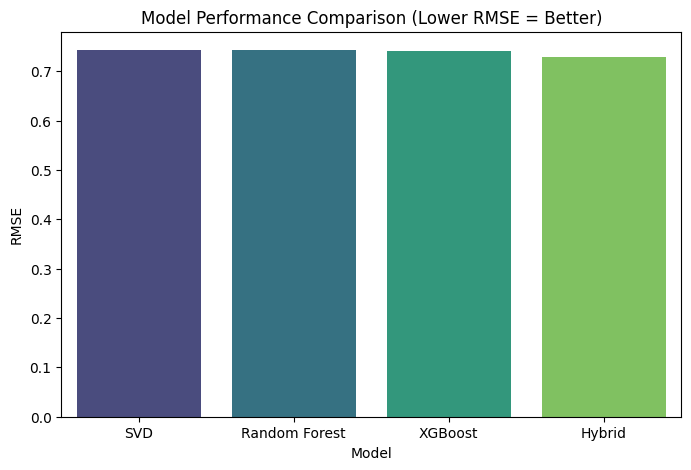


Model Comparison Table:
            Model      RMSE
0            SVD  0.742413
1  Random Forest  0.743081
2        XGBoost  0.740776
3         Hybrid  0.729361


In [25]:
results = {
    "SVD": svd_rmse,
    "Random Forest": rf_rmse,
    "XGBoost": xgb_rmse,
    "Hybrid": hybrid_rmse
}

results_df = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="RMSE", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (Lower RMSE = Better)")
plt.ylabel("RMSE")
plt.show()

print("\nModel Comparison Table:\n", results_df)


Lower RMSE Better Model.                                         
Hybrid Model has lower RMSE ,We will deploy the Hybrid Model.      
To deploy we will save the model

In [ ]:
import joblib, pickle

# Save ML models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(xgb, "xgboost_model.pkl")
joblib.dump(scaler, "scaler.pkl")

with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd, f)

print(" Models saved successfully.")

df_encoded.to_csv("df_encoded.csv", index=False)
cat_cols = ['course_name', 'instructor', 'certification_offered',
            'difficulty_level', 'study_material_available']

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le

joblib.dump(encoders, "encoders.pkl")

print(" Encoded dataframe & encoders saved successfully.")


✅ Models saved successfully.
✅ Encoded dataframe & encoders saved successfully.
